# Image stack packager

This tool packages data. The data are stacks of images off of a brightfield microscope. The images reside in an Allen Institute repository, [the Cell Types Database](http://reconstrue.com/data_sources/allen_institute/cell_types_db.html). This tool downloads a stack of images and generates a JSON manifest of the files. If the repository contains a skeleton file (`*.swc`) for the neuron, that too is downloaded. All output artifacts are files in a single directory.

This notebook has been tested to work on Google's Colab and vanilla JupyterLab.


## Legal

This code is [licensed by Reconstrue under the Apache 2.0 License](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/blob/master/LICENSE).


In [0]:
# Copyright 2019-2020 Reconstrue Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Setup

The Allen Institute maintains the Allen SDK, `allensdk`, for accessing their data products. Colab has tons of Python packages pre-installed but `allensdk` is not one of them. For more details about working with `allensdk` on Colab, see Reconstrue's [AllenSDK on Colab](http://reconstrue.com/data_sources/allen_institute/allensdk_on_colab.html). For now, simply install the SDK.

In [0]:
!pip3 --quiet install tornado datashader allensdk

In [17]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import imghdr
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import skimage.io
import urllib.parse

from IPython.display import display
from PIL import Image

As of late 2019, Colab "has a Data Table extension that allows interactive exploration of pandas dataframes with filtering and sorting." [[*](https://colab.research.google.com/notebooks/data_table.ipynb)]


In [0]:
%load_ext google.colab.data_table


## Accessing data

The images can be accessed through a web UI and/or programatically in Python.

A nice feature of the Allen Institute's set-up is that they do not require *any* auth to get to the public data.

### brain-map.org web UI

[brain-map.org](http://brain-map.org) is where the target images reside. The repository has a web UI, wherein the image stack can be viewed. Here is an example from their documentation [[*](http://help.brain-map.org/display/celltypes/Physiology+and+Morphology)]:

>displays two orthogonal projections of the biocytin filled neuron and the neuron's 3D morphology reconstruction. From this page, you can also view the stack of high resolution images used for the reconstruction.

![](http://help.brain-map.org/download/attachments/8323624/MorphBrowse.PNG?version=1&modificationDate=1476664307214&api=v2)

So, we can explore the web UI to preview what the images look like but we want to download them via Python code:

> You can also access the data programatically and obtain sample code to run your own model simulations. For more details go to the Download page. 



### RESTful RMA

The second way to access the data is through the RESTful "RMA" interface.


### Allen SDK

The Allen Institute first came up with a RESTful interface to their resources, called [RMA](http://help.brain-map.org/pages/viewpage.action?pageId=5308449). RMA is a [HATEOAS](https://restfulapi.net/hateoas/) style RESTful API. Later they added the Python SDK as client-side convenience wrapper code around the RMA.

The `allensdk` is Python code which provides a programmatic interface to the info available via RMI. It also maintains a cache of files for performance purposes (`allensdk.core.cell_types_cache.CellTypesCache`).

Although `allensdk` can provide metadata about cells in the repository, it does not have methods to acquire the raw image stack. To get the raw images, RMI is the only method. So, `allensdk` can provide IDs of available cells, but further work is required to then iterate through the stack and grab each file.



## Exploring RMA

Their documentation includes [example URLs for fetching data](http://help.brain-map.org/display/celltypes/API#API-morphology_image_download). Let's express those in a Jupyter notebook.

json_query_url = "http://api.brain-map.org/api/v2/data/query.json?criteria=model::ProjectionImage,rma::criteria,[specimen_id$eq313862022]"




### Images into markdown

First up would be simply an image in markdown, using their sample URL :
> [`http://api.brain-map.org/api/v2/section_image_download/323637357`](http://api.brain-map.org/api/v2/section_image_download/323637357)

That image is a JPEG, less than 2 MB, ~5k x ~7k pixels. According to the docs:
>images were first stitched from tiles in Tiff format, white balanced and finally converted to JPEG 2000 file format. Aperio ScanScope images were first converted to JPEG 2000 format, then orientation adjusted and white balanced. In either case, the final products were images in JPEG 2000 compressed format for further pipeline processing and analysis.


The square grid is an artifact of the image tile stitching algorithm that has been used to assemble this whole slide image:

<img src="http://api.brain-map.org/api/v2/section_image_download/323637357" height='450px' />

### Images into Python



#### URL encode queries
First thing to note, some of the examples they give work but need to be URL encoded otherwise, results will come back but not be what is to be expected. For example, they provide an example:
```
http://api.brain-map.org/api/v2/data/query.json?criteria=model::ProjectionImage,rma::criteria,[specimen_id$eq313862022]
```
That will return some JSON but not just about specimen_id 313862022.

But URL encode it and it works as expected:
```
http://api.brain-map.org/api/v2/data/query.json?criteria=model%3A%3AProjectionImage%2Crma%3A%3Acriteria%2C%5Bspecimen_id%24eq313862022%5D"
```





In [12]:
# Download an image file

an_img_url = "http://api.brain-map.org/api/v2/section_image_download/321549675"
#an_img_url = "http://api.brain-map.org/api/v2/section_image_download/323637357"
an_img_file_name = "/content/an_image"
!wget --no-verbose --progress=bar:force:noscroll -O {an_img_file_name} {an_img_url} 

2020-04-05 05:00:51 URL:http://api.brain-map.org/cgi-bin/imageservice?mime=1&path=/external/mousecelltypes/prod143/0500304445-0002_321549658/0500304445-0002.aff&left=1&top=1&width=5760&height=7568&downsample=0 [2002988] -> "/content/an_image" [1]


In [22]:
# Get stats on image file just downloaded
print(f"Detected image file type: {imghdr.what(an_img_file_name)}")
!echo -----------
!ls -lh {an_img_file_name}



Detected image file type: jpeg
-----------
-rw-r--r-- 1 root root 2.0M Sep 25  2019 /content/an_image


In [24]:
!ffprobe {an_img_file_name}

ffprobe version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2007-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --en

In [0]:
slide_img = Image.open(an_img_file_name)
display(slide_img)


Seemingly when querying, data can be requested in multiple formats: XML, JSON, and CSV.


### As XML

In [0]:
xml_request_url = "http://api.brain-map.org/api/v2/data/query.xml?criteria=model::ProjectionImage,rma::criteria,[specimen_id$eq313862022]"
xml_file_name = "response.xml"
!wget -O {xml_file_name} {xml_request_url}

--2020-03-26 20:05:48--  http://api.brain-map.org/api/v2/data/query.xml?criteria=model::ProjectionImage,rma::criteria,[specimen_id]
Resolving api.brain-map.org (api.brain-map.org)... 63.237.233.29
Connecting to api.brain-map.org (api.brain-map.org)|63.237.233.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/xml]
Saving to: ‘response.xml’

response.xml            [ <=>                ]  47.38K   278KB/s    in 0.2s    

2020-03-26 20:05:48 (278 KB/s) - ‘response.xml’ saved [48518]



In [0]:
!cat {xml_file_name}

That's nice: for each image stack, they provide both MaximumIntensityProjection and MinimumIntensityProjection from both the frontal view plane (xy) and one of the two side views (yz plane).

### As JSON

This is exactly the same as the above XML response, except in the requested URL `/query.xml?` is changed to `/query.json?` 

In [0]:
json_file_name = "/content/response.json"

query_url_root = 'http://api.brain-map.org/api/v2/data/query.json?criteria='
query_encoded = urllib.parse.quote('model::ProjectionImage,rma::criteria,[specimen_id$eq313862022]')
json_query_url = query_url_root + query_encoded

In [12]:
!wget -O {json_file_name} {json_query_url}

--2020-03-30 01:45:35--  http://api.brain-map.org/api/v2/data/query.json?criteria=model%3A%3AProjectionImage%2Crma%3A%3Acriteria%2C%5Bspecimen_id%24eq313862022%5D
Resolving api.brain-map.org (api.brain-map.org)... 63.237.233.29
Connecting to api.brain-map.org (api.brain-map.org)|63.237.233.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘/content/response.json’

/content/response.j     [ <=>                ]   2.31K  --.-KB/s    in 0s      

2020-03-30 01:45:35 (336 MB/s) - ‘/content/response.json’ saved [2368]



Cell Types DB docs say [[*](http://help.brain-map.org/display/celltypes/API#API-download_swc)]:
> The API provides programmatic access to the microscopy images used for reconstruction, axis-oriented projections of those images, and morphological reconstructions.  A cell can have up to four axis-oriented projections of the images used for reconstruction:
- XY minimum intensity projection
- YZ minimum intensity projection
- XY maximum intensity projection
- YZ maximum intensity projection

> The reconstruction images display a dark, biocytin-filled cell on a light background. The maximum intensity projections are constructed from inverted and contrast-enhanced versions of the morphology images, resulting in a light cell on a dark background.


In [13]:
with open(json_file_name) as f:
  eg_data = json.load(f)

print(json.dumps(eg_data, indent=2))

{
  "success": true,
  "id": 0,
  "start_row": 0,
  "num_rows": 4,
  "total_rows": 4,
  "msg": [
    {
      "annotated": false,
      "axes": "xy",
      "bits_per_component": 8,
      "data_set_id": null,
      "expression": null,
      "expression_path": null,
      "failed": false,
      "height": 7570,
      "id": 324089927,
      "image_height": 7570,
      "image_type": "MaximumIntensityProjection - xy",
      "image_width": 5762,
      "isi_experiment_id": null,
      "lims1_id": null,
      "number_of_components": 1,
      "ophys_experiment_id": null,
      "path": "/external/mousecelltypes/prod146/specimen_313862022/max_xy_313862022.aff",
      "projection_function": "max",
      "resolution": 0.1144,
      "section_number": 0,
      "specimen_id": 313862022,
      "structure_id": null,
      "tier_count": 6,
      "width": 5762,
      "x": 0,
      "y": 0
    },
    {
      "annotated": false,
      "axes": "xy",
      "bits_per_component": 8,
      "data_set_id": null,
    

So, the above is saying that for specimen_id `13862022` there are 4 image available:
- 2 Min intensity projections (XY plane and YZ plane)
- 2 Max intensity projections (XY plane and YZ plane)

For brightfield, the more natural projection is minimum, not maximum, and the XY project is the more interesting of the two part mugshot projections. So, we want the one with:
```
"image_type": "MinimumIntensityProjection - xy"
```
Or equivalently: `projection_function` == min and `axes` == xy.

Finally, for a download URL, grab that projection's `id` and stick it on the end end of the following:
```
http://api.brain-map.org/api/v2/section_image_download/
```

For example,
```
http://api.brain-map.org/api/v2/section_image_download/323637357
```

Which, in markdown at width=200px looks like:

<img src="http://api.brain-map.org/api/v2/section_image_download/323637357" width="200px" />




#### Query for all images in a stack

http://help.brain-map.org/display/celltypes/API:
>Find all images used for reconstruction for a layer 4 spiny cell (Specimen 313862022)
```
http://api.brain-map.org/api/v2/data/query.xml?criteria=
model::SubImage
,rma::criteria,data_set[specimen_id$eq313862022]
![alt text](https://)
```

In [16]:
json_file_name = "/content/response.json"

query_url_root = 'http://api.brain-map.org/api/v2/data/query.json?criteria='
query_encoded = urllib.parse.quote('model::SubImage,rma::criteria,data_set[specimen_id$eq313862022]')
json_query_url = query_url_root + query_encoded

!wget -O {json_file_name} {json_query_url}

with open(json_file_name) as f:
  eg_data = json.load(f)

print(json.dumps(eg_data, indent=2))

--2020-03-30 02:14:14--  http://api.brain-map.org/api/v2/data/query.json?criteria=model%3A%3ASubImage%2Crma%3A%3Acriteria%2Cdata_set%5Bspecimen_id%24eq313862022%5D
Resolving api.brain-map.org (api.brain-map.org)... 63.237.233.29
Connecting to api.brain-map.org (api.brain-map.org)|63.237.233.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘/content/response.json’

/content/response.j     [ <=>                ]  27.08K  --.-KB/s    in 0.1s    

2020-03-30 02:14:14 (232 KB/s) - ‘/content/response.json’ saved [27729]

{
  "success": true,
  "id": 0,
  "start_row": 0,
  "num_rows": 50,
  "total_rows": 627,
  "msg": [
    {
      "annotated": false,
      "axes": null,
      "bits_per_component": 8,
      "data_set_id": 321549626,
      "expression": null,
      "expression_path": null,
      "failed": false,
      "height": 7568,
      "id": 321549654,
      "image_height": 7570,
      "image_type": "Primary",
      "imag

Seems they all have `data_set_id`: 321549626 so that is the ID of the image stack? Or is the stack only part of it?

### RmaApi

The above sort of query construction gets old quick, and is just sloppy and lame. So, the Allen folks have Python utility classes for such tasks: [RMA Database and Service API](http://alleninstitute.github.io/AllenSDK/data_api_client.html).


### ImageDownloadApi

http://alleninstitute.github.io/AllenSDK/allensdk.api.queries.image_download_api.html#allensdk.api.queries.image_download_api.ImageDownloadApi

Note:
>By default, an unfiltered full-sized image with the highest quality is returned as a download if no parameters are provided.

### To Pandas

The JSON is shaped ala:
```json
{
  "success": true,
  "id": 0,
  "start_row": 0,
  "num_rows": 50,
  "total_rows": 2686,
  "msg": [
    {
```
There is some pagination going on via `start_row`, `num_rows`, and `total_rows`.

The `msg` array is what we want to feed to Pandas. Here's a hacky, lazy way to perform that task via `pandas.read_json`.



In [14]:
rows_json = eg_data["msg"]

# Write to FS
processed_json_file_name = "/content/query_trimmed.json"
with open(processed_json_file_name, 'w') as json_dest_file:
  json.dump(rows_json, json_dest_file) 

# Test file just written to
with open(processed_json_file_name) as f:
  test_data = json.load(f)

print(json.dumps(test_data, indent=2))



[
  {
    "annotated": false,
    "axes": "xy",
    "bits_per_component": 8,
    "data_set_id": null,
    "expression": null,
    "expression_path": null,
    "failed": false,
    "height": 7570,
    "id": 324089927,
    "image_height": 7570,
    "image_type": "MaximumIntensityProjection - xy",
    "image_width": 5762,
    "isi_experiment_id": null,
    "lims1_id": null,
    "number_of_components": 1,
    "ophys_experiment_id": null,
    "path": "/external/mousecelltypes/prod146/specimen_313862022/max_xy_313862022.aff",
    "projection_function": "max",
    "resolution": 0.1144,
    "section_number": 0,
    "specimen_id": 313862022,
    "structure_id": null,
    "tier_count": 6,
    "width": 5762,
    "x": 0,
    "y": 0
  },
  {
    "annotated": false,
    "axes": "xy",
    "bits_per_component": 8,
    "data_set_id": null,
    "expression": null,
    "expression_path": null,
    "failed": false,
    "height": 7570,
    "id": 323637357,
    "image_height": 7570,
    "image_type": "Minim

In [15]:
# specimen_id is the id of the cell imaged, id is the id of an image
query_df = pd.read_json(processed_json_file_name)
query_df.sort_values(by=['id'])

,annotated,axes,bits_per_component,data_set_id,expression,expression_path,failed,height,id,image_height,image_type,image_width,isi_experiment_id,lims1_id,number_of_components,ophys_experiment_id,path,projection_function,resolution,section_number,specimen_id,structure_id,tier_count,width,x,y
1,False,xy,8,NaN,NaN,NaN,False,7570,323637357,7570,MinimumIntensityProjection - xy,5762,NaN,NaN,1,NaN,/external/mousecelltypes/prod146/specimen_3138...,min,0.1144,0,313862022,NaN,6,5762,0,0
3,False,yz,8,NaN,NaN,NaN,False,7570,323637359,7570,MinimumIntensityProjection - yz,1534,NaN,NaN,1,NaN,/external/mousecelltypes/prod146/specimen_3138...,min,0.1144,0,313862022,NaN,6,1534,0,0
0,False,xy,8,NaN,NaN,NaN,False,7570,324089927,7570,MaximumIntensityProjection - xy,5762,NaN,NaN,1,NaN,/external/mousecelltypes/prod146/specimen_3138...,max,0.1144,0,313862022,NaN,6,5762,0,0
2,False,yz,8,NaN,NaN,NaN,False,7570,324089932,7570,MaximumIntensityProjection - yz,1534,NaN,NaN,1,NaN,/external/mousecelltypes/prod146/specimen_3138...,max,0.1144,0,313862022,NaN,6,1534,0,0


## Query CTDB for neurons





In [26]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

cells = ctc.get_cells(require_reconstruction=True, require_morphology=True, species=[CellTypesApi.MOUSE])
print('Number of mouse cells with images and SWC files: %i' % len(cells))

Number of mouse cells with images and SWC files: 485


## Explore a skeleton file

[[Allen docs](http://help.brain-map.org/display/celltypes/API#API-morphology_image_download)]:
>Find the reconstruction file for one of those cells
```
http://api.brain-map.org/api/v2/data/query.xml?criteria=model::NeuronReconstruction,rma::criteria,[specimen_id$eq313862306],rma::include,well_known_files
```
>Download the reconstruction file
```
http://api.brain-map.org/api/v2/well_known_file_download/491119517
```

Separately, the [Cell Types examples docs](http://help.brain-map.org/display/celltypes/API#API-CellTypesExamples) includes:
>Download the reconstruction file
>`http://api.brain-map.org/api/v2/well_known_file_download/491119517`

So, two examples indicating that SWC files can be downloaded via:
```
tp://api.brain-map.org/api/v2/well_known_file_download/<some_id>
```

GETting `491119517` will respond with a document which the server suggests should be named `Sst-IRES-Cre_Ai14-167636.04.01.01_491119515_m.swc` so why not:


In [0]:
src_url = "http://api.brain-map.org/api/v2/well_known_file_download/491119517"
dest_file_name = "Sst-IRES-Cre_Ai14-167636.04.01.01_491119515_m.swc"

downloaded_doc = requests.get(src_url)
with open(dest_file_name, 'wb') as f:
  f.write(downloaded_doc.content)


In [4]:
!head {dest_file_name}

# generated by Vaa3D Plugin sort_neuron_swc
# source file(s): C:/Users/alexh/Desktop/Check then delete/Sst-IRES-Cre_Ai14_IVSCC_-167636.04.01.01_475125280_p.swc_Z_T10.swc
# id,type,x,y,z,r,pid
1 1 351.4368 288.9744 21.84 5.1218 -1
2 3 355.7485 290.5886 20.9126 0.2796 1
3 3 356.8765 290.7179 20.4691 0.3559 2
4 3 358.0045 290.5966 20.2896 0.4449 3
5 3 359.0719 290.2374 20.0491 0.5084 4
6 3 360.0557 289.6974 19.755 0.5212 5
7 3 360.9732 289.0488 19.433 0.483 6


### SWC format

SWC is an ASCII text file format. 

[AllenSDK on SWC file format spec](https://alleninstitute.github.io/AllenSDK/cell_types.html). 
>The SWC file format is a white-space delimited text file with a standard set of headers. The file lists a set of 3D neuronal compartments, each of which has:


Column | Data Type |Description
-- | -- | --
id | string | compartment ID
type | integer | compartment type
x|float|3D compartment position (x)
y|float|3D compartment position (y)
z|float|3D compartment position (z)
radius|float|compartment radius
parent|string|parent compartment ID

>Comment lines begin with a ‘#’. Reconstructions in the Allen Cell Types Database can contain the following compartment types:

Type|Description
--|--
0|unknown
1|soma
2|axon
3|basal dendrite
4|apical dendrite



Let's see what The Allen puts in those SWC files.

In [5]:
# Load data from SWC file into a Panda's DataFrame, the view via google.colab.data_table.DataTable
from google.colab.data_table import DataTable

segments = pd.read_csv(dest_file_name, sep=" ", names=["id", "type", "x", "y", "z", "r", "pid"], skiprows=[0,1,2], index_col=0)
segments.dtypes

type      int64
x       float64
y       float64
z       float64
r       float64
pid       int64
dtype: object

In [6]:
DataTable(segments)

,type,x,y,z,r,pid
id,,,,,,
1,1,351.4368,288.9744,21.8400,5.1218,-1
2,3,355.7485,290.5886,20.9126,0.2796,1
3,3,356.8765,290.7179,20.4691,0.3559,2
4,3,358.0045,290.5966,20.2896,0.4449,3
5,3,359.0719,290.2374,20.0491,0.5084,4
...,...,...,...,...,...,...
2189,3,331.6605,322.7075,14.3144,0.2924,2188
2190,3,331.2189,323.7623,14.3482,0.3051,2189
2191,3,330.8173,324.8331,14.4005,0.2924,2190


Row `ID`==1 has `type` = `1` which means "soma." Notice how there is only one type == `1` row. So the `r` is the radius they use for the spherical representation of a soma. Note that in this example the radius of the soma is over 20 times the diameter of the stems that branch off it. E.g.:

![](https://cdn.psychologytoday.com/sites/default/files/styles/image-article_inline_full_caption/public/field_blog_entry_images/2017-10/pyramidal_cell_detail.jpg?itok=iPiTb5Nq)

### Render skeleton projection

Plot skeleton atop inverted MinIP
First thing to do is what The Allen has in their own SDK docs: Cell Types examples. So, let us install the AllenSDK.

(Reconstrue has a separate notebook, allensdk_on_colab.ipynb, which deals with nothing except deploying AllenSDK on Colab. That notebook goes into the topic deeper than neccessary here but if complications arise on this front, it has various debug utilities.)

Total number of compartents about to (slowly) plot: 2193


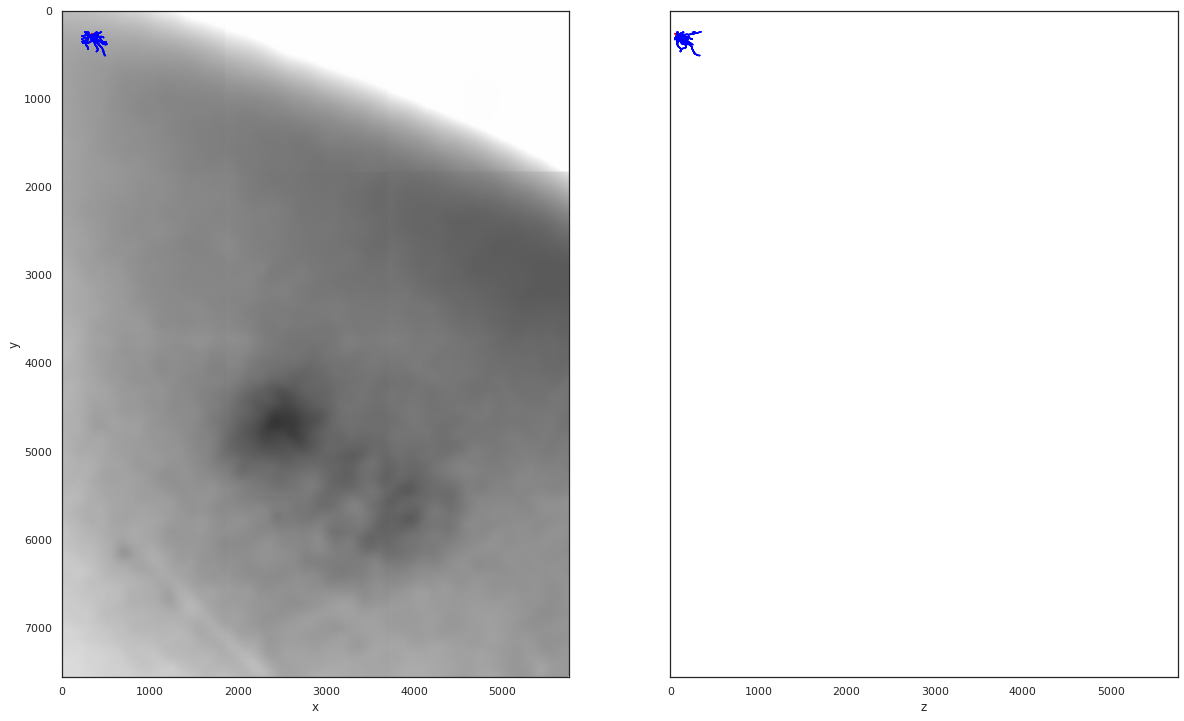

In [15]:
from allensdk.core.swc import read_swc

# https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/swc.html
morphology = read_swc(dest_file_name)
print("Total number of compartents about to (slowly) plot: %d" % len(morphology.compartment_list))


from allensdk.core.swc import Marker

# TODO: set depths of z axis base on image_stack_height, so depth coding consistent across images and skeleton UIs.


sns.set(style="white")

fig, axes = plt.subplots(1, 2, figsize=(20,20), sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box') # 'box-forced'

projection = skimage.io.imread(an_img_file_name)
axes[0].imshow(projection, cmap = plt.cm.gray_r)

# Make a line drawing of x-y and y-z views
# TODO: why is this so slow?
# TODO: sort by type first, in order to get blue atop red like Allen images
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        if c["type"] == 2:
            skeleton_color = "red"
        else:
            skeleton_color = "blue"
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color=skeleton_color)
        # TODO: clean up this stretch factor & axis
        axes[1].plot([3.5 * n['z'], 3.5 * c['z']], [n['y'], c['y']], color=skeleton_color)

# cut dendrite markers
#dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]
#
#axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
#axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
#nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]
#
#axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
#axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
# TODO: legend of blue & red. Title.
plt.show()
pass # suppress <output noise> TODO: not supressing the <Figure size ... message

# TODO: save axex[0] to fileystem, then load in Plotly image viewer for zoom & pan

## References
Allen Cell Types Database docs
- [Technical White Paper: Cell Morphology and Histology](http://help.brain-map.org/download/attachments/8323525/CellTypes_Morph_Overview.pdf?version=4&modificationDate=1528310097913&api=v2)
- [Cell Types API](http://help.brain-map.org/display/celltypes/API)
- [ImageDownloadApi.download_image()](http://alleninstitute.github.io/AllenSDK/allensdk.api.queries.image_download_api.html#allensdk.api.queries.image_download_api.ImageDownloadApi)
- [RESTful Model Access (RMA)](http://help.brain-map.org/pages/viewpage.action?pageId=5308449)


# TODO:


[Downloading an Image](http://help.brain-map.org/display/api/Downloading+an+Image?_ga=2.163925180.220025037.1585532917-183509947.1585532917):
> Prototype: 
```
http://api.brain-map.org/api/v2/image_download/[SubImage.id]?downsample=[#]&quality=[#]&view=[expression|projection|tumor_feature_annotation|tumor_feature_boundary]
```

>Download all of the sagittal images in the Mouse Brain Atlas for the gene Adora2a at full resolution.  
>First, search for relevant experiments' IDs (SectionDataSets):
```
http://api.brain-map.org/api/v2/data/query.xml?criteria=model::SectionDataSet,rma::criteria,[failed$eq'false'],products[abbreviation$eq'Mouse'],plane_of_section[name$eq'sagittal'],genes[acronym$eq'Adora2a']
```
>Second, retrieve a list of all images for one of the experiments (SectionImages):
```
http://api.brain-map.org/api/v2/data/query.xml?criteria=model::SectionImage,rma::criteria,[data_set_id$eq70813257]
```
Finally, iterate through the list of images and call the SectionImage Download Service with their IDs:
```
http://api.brain-map.org/api/v2/image_download/70679088
```

>quality (Integer optional): The jpeg quality of the returned image. This must be an integer from 0, for the lowest quality, up to as high as 100. If it is not specified, it defaults to the highest quality.